<a href="https://colab.research.google.com/github/mushagasha-h/Firms-ESG-performance-analysis/blob/main/Firms_ESG_performance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Python Code for ESG Data Analysis and Statistical Testing**

In [ ]:
# Install required dependencies
!pip install statsmodels openpyxl scikit_posthocs

# Import required libraries
# Standard library
import warnings
from itertools import combinations

# Scientific computing & data analysis
import numpy as np
import pandas as pd
import scipy.stats as stats

# Statistical models & post-hoc tests
from statsmodels.stats.multitest import multipletests
import scikit_posthocs as sp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress unnecessary warnings
warnings.filterwarnings('ignore')


In [ ]:
# Load the data
file_path = '/content/ESG_scores_with_industry_group.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Display the first few rows to understand the structure
df.head()

,Identifier (RIC),Company Name,ESG_Score,ESG_Combined Score,ESG_Controversies Score,Environmental_Pillar_Score,Social_Pillar_Score,Governance_Pillar_Score,GICS_Industry_Name,Unnamed: 9,Region,GICS_Industry_Group
0,POOL.OQ,Pool Corp,58.574902,58.574902,100.000000,46.722325,39.141401,89.803856,Distributors,United States of America,North America,Retailing
1,CHRW.OQ,CH Robinson Worldwide Inc,39.943751,39.943751,83.333333,39.444812,55.698261,20.061613,Air Freight & Logistics,United States of America,North America,Transportation
2,AJG.N,Arthur J. Gallagher & Co.,57.751701,57.751701,100.000000,42.751677,55.605538,65.255565,Insurance,United States of America,North America,Insurance
3,CNP.N,CenterPoint Energy Inc,45.975499,25.260477,4.545455,38.604528,29.633760,82.666408,Multi-Utilities,United States of America,North America,Utilities
4,AMCR.N,Amcor PLC,66.811439,43.405720,20.000000,60.648081,65.350064,78.738140,Containers & Packaging,Switzerland,Europe,Materials


*Descriptive Statistics*

In [ ]:
# Select only numeric columns for statistical analysis
numeric_df = df.select_dtypes(include='number')

# Compute basic statistics
statistics = numeric_df.describe().T

# Add variance and interquartile range (IQR)
statistics["variance"] = numeric_df.var()
statistics["IQR"] = numeric_df.quantile(0.75) - numeric_df.quantile(0.25)

#round for readability
statistics = statistics.round(4)

# Display the statistics
print("Descriptive Statistics for Numeric Columns:\n")
print(statistics)

Descriptive Statistics for Numeric Columns:

                             count     mean      std     min       25%  \
ESG_Score                   5410.0  46.8224  20.3422  0.2902   30.3054   
ESG_Combined Score          5410.0  44.0263  18.7332  0.2902   29.4736   
ESG_Controversies Score     5410.0  85.7745  28.3518  0.3067  100.0000   
Environmental_Pillar_Score  5410.0  41.5307  28.1752  0.0000   16.1550   
Social_Pillar_Score         5410.0  48.6053  23.4388  0.5104   29.6231   
Governance_Pillar_Score     5410.0  47.4613  24.0419  0.0000   28.0318   

                                 50%       75%       max  variance      IQR  
ESG_Score                    46.4045   63.3571   92.7905  413.8054  33.0516  
ESG_Combined Score           43.5479   58.2579   90.8528  350.9336  28.7843  
ESG_Controversies Score     100.0000  100.0000  100.0000  803.8271   0.0000  
Environmental_Pillar_Score   42.7239   65.0919   98.7907  793.8433  48.9370  
Social_Pillar_Score          48.9134   67.7835

*Assumptions checks*

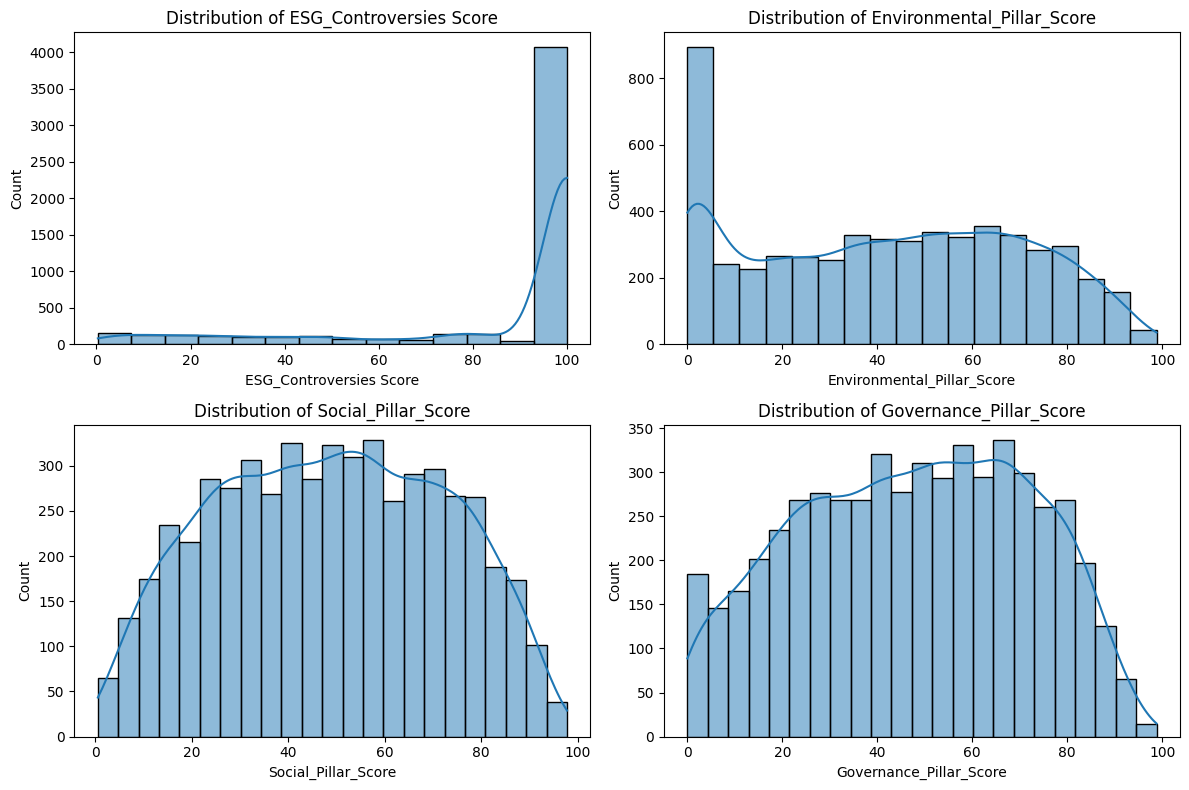


--- Normality Test Results (Shapiro–Wilk) ---
ESG_Controversies Score: W=0.559, p=2.61e-79
Environmental_Pillar_Score: W=0.945, p=7.94e-41
Social_Pillar_Score: W=0.976, p=4.39e-29
Governance_Pillar_Score: W=0.975, p=6.68e-30

--- Levene’s Test Results (Homogeneity of Variance) ---
  Grouping Variable                     Metric  Levene Statistic  p-value Equal Variances?
GICS_Industry_Group    ESG_Controversies Score             6.418 1.48e-17               No
GICS_Industry_Group Environmental_Pillar_Score             4.344 3.31e-10               No
GICS_Industry_Group        Social_Pillar_Score             2.046 3.92e-03               No
GICS_Industry_Group    Governance_Pillar_Score             2.771 3.81e-05               No
             Region    ESG_Controversies Score           106.095 3.82e-87               No
             Region Environmental_Pillar_Score            18.546 3.77e-15               No
             Region        Social_Pillar_Score             8.827 4.23e-07       

In [ ]:
import seaborn as sns
from scipy.stats import levene
import seaborn as sns


# Select relevant columns
cols = ["ESG_Controversies Score", "Environmental_Pillar_Score", "Social_Pillar_Score", "Governance_Pillar_Score"]
subset = df[cols].dropna()

# Normality tests (Shapiro–Wilk)
normality_results = {}
for col in cols:
    shapiro_test = stats.shapiro(subset[col])
    normality_results[col] = {
        "Shapiro-Wilk W": shapiro_test[0],
        "p-value": shapiro_test[1]
    }

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(subset[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

# Levene’s Test (Homogeneity of Variance)
group_vars = ["GICS_Industry_Group", "Region"]
levene_results = {}

for group_col in group_vars:
    levene_results[group_col] = {}
    for col in cols:
        groups = [subset[col][df[group_col] == g].dropna()
                  for g in df[group_col].dropna().unique()]
        stat, p = levene(*groups)
        levene_results[group_col][col] = {
            "Levene Statistic": stat,
            "p-value": p
        }

# Results Formatting into a table
records = []
for group_col, results in levene_results.items():
    for metric, values in results.items():
        records.append({
            "Grouping Variable": group_col,
            "Metric": metric,
            "Levene Statistic": round(values["Levene Statistic"], 3),
            "p-value": f"{values['p-value']:.2e}",
            "Equal Variances?": "Yes" if values["p-value"] > 0.05 else "No"
        })

levene_table = pd.DataFrame(records)

# Display results
print("\n--- Normality Test Results (Shapiro–Wilk) ---")
for k, v in normality_results.items():
    print(f"{k}: W={v['Shapiro-Wilk W']:.3f}, p={v['p-value']:.2e}")

print("\n--- Levene’s Test Results (Homogeneity of Variance) ---")
print(levene_table.to_string(index=False))

# **RESEARCH QUESTION 1**
*Do ESG pillar performances differ significantly across industries and regions?*

*Kruskal Wallis Test Results*

In [ ]:
from scipy.stats import kruskal

# Define the grouping columns and the score columns to test
grouping_columns = ['Region', 'GICS_Industry_Group']
pillar_columns = ['Environmental_Pillar_Score', 'Social_Pillar_Score', 'Governance_Pillar_Score']

# Function to perform Kruskal-Wallis test for a specific pillar and grouping
def perform_kruskal_test(df, group_by_column, target_column):
    grouped_data = df[[group_by_column, target_column]].dropna().groupby(group_by_column)
    samples = [group[target_column].values for name, group in grouped_data if len(group) > 1]

    if len(samples) > 1:
        stat, p = kruskal(*samples)
        return pd.Series({'Statistic': stat, 'p-value': p})
    else:
        return pd.Series({'Statistic': None, 'p-value': None})

# Run Kruskal-Wallis tests
results = []

for pillar in pillar_columns:
    for group in grouping_columns:
        result = perform_kruskal_test(df, group, pillar)
        result['Pillar'] = pillar
        result['Grouped By'] = group
        results.append(result)

# Convert results to DataFrame
kruskal_results = pd.DataFrame(results)

# Diplay the Kruskal Wallis test Results
kruskal_results

,Statistic,p-value,Pillar,Grouped By
0,656.442500,9.393128e-141,Environmental_Pillar_Score,Region
1,689.586594,3.530956e-133,Environmental_Pillar_Score,GICS_Industry_Group
2,315.004372,6.276320e-67,Social_Pillar_Score,Region
3,104.873456,1.674143e-13,Social_Pillar_Score,GICS_Industry_Group
4,245.404593,6.359857e-52,Governance_Pillar_Score,Region
5,181.369696,5.235324e-28,Governance_Pillar_Score,GICS_Industry_Group


*Dunn's Test with Bonferroni Correction*

In [ ]:
import scikit_posthocs as sp

# Dunn’s Test Post-hoc Analysis (only significant comparisons)

def run_dunn_test_significant(df, value_col, group_col, alpha=0.05):
    # Drop rows where either the pillar score or grouping is NaN
    clean_df = df[[value_col, group_col]].dropna()

    # Run Dunn’s test with Bonferroni correction
    result = sp.posthoc_dunn(
        clean_df,
        val_col=value_col,
        group_col=group_col,
        p_adjust='bonferroni'
    )

    # Extract significant comparisons only
    sig_records = []
    for i in result.index:
        for j in result.columns:
            if i < j:  # avoid duplicates (matrix is symmetric)
                pval = result.loc[i, j]
                if pval < alpha:
                    sig_records.append({
                        "Grouping Variable": group_col,
                        "Metric": value_col,
                        "Comparison": f"{i} vs {j}",
                        "p-value": round(pval, 3)
                    })

    return pd.DataFrame(sig_records)

# ESG pillars to test
pillars = ["Environmental_Pillar_Score", "Social_Pillar_Score", "Governance_Pillar_Score"]

# Grouping variables
groupings = ["Region", "GICS_Industry_Group"]

# Store results in dictionary
dunn_results = {}

for group in groupings:
    for pillar in pillars:
        key = f"{pillar}_{group}"
        result_df = run_dunn_test_significant(df, pillar, group)
        dunn_results[key] = result_df

        print(f"\n--- Significant Dunn’s Test Results for {pillar} by {group} ---")
        if not result_df.empty:
            display(result_df)
            # Save only significant results to CSV
            csv_filename = f"Dunn_{pillar}_{group}_significant.csv"
            result_df.to_csv(csv_filename, index=False)
            print(f"Saved significant results to {csv_filename}")
        else:
            print("No significant comparisons found.")


--- Significant Dunn’s Test Results for Environmental_Pillar_Score by Region ---


,Grouping Variable,Metric,Comparison,p-value
0,Region,Environmental_Pillar_Score,Asia vs Europe,0.000
1,Region,Environmental_Pillar_Score,Asia vs Latin America,0.000
2,Region,Environmental_Pillar_Score,Asia vs North America,0.000
3,Region,Environmental_Pillar_Score,Australia vs Europe,0.001
4,Region,Environmental_Pillar_Score,Australia vs Latin America,0.005
5,Region,Environmental_Pillar_Score,Europe vs North America,0.000
6,Region,Environmental_Pillar_Score,Latin America vs North America,0.000


Saved significant results to Dunn_Environmental_Pillar_Score_Region_significant.csv

--- Significant Dunn’s Test Results for Social_Pillar_Score by Region ---


,Grouping Variable,Metric,Comparison,p-value
0,Region,Social_Pillar_Score,Asia vs Europe,0.0
1,Region,Social_Pillar_Score,Asia vs Latin America,0.0
2,Region,Social_Pillar_Score,Europe vs North America,0.0
3,Region,Social_Pillar_Score,Latin America vs North America,0.0


Saved significant results to Dunn_Social_Pillar_Score_Region_significant.csv

--- Significant Dunn’s Test Results for Governance_Pillar_Score by Region ---


,Grouping Variable,Metric,Comparison,p-value
0,Region,Governance_Pillar_Score,Asia vs Europe,0.00
1,Region,Governance_Pillar_Score,Asia vs North America,0.00
2,Region,Governance_Pillar_Score,Europe vs Latin America,0.01
3,Region,Governance_Pillar_Score,Europe vs North America,0.00
4,Region,Governance_Pillar_Score,Latin America vs North America,0.00


Saved significant results to Dunn_Governance_Pillar_Score_Region_significant.csv

--- Significant Dunn’s Test Results for Environmental_Pillar_Score by GICS_Industry_Group ---


,Grouping Variable,Metric,Comparison,p-value
0,GICS_Industry_Group,Environmental_Pillar_Score,Automobiles & Components vs Banks,0.000
1,GICS_Industry_Group,Environmental_Pillar_Score,Automobiles & Components vs Consumer Services,0.001
2,GICS_Industry_Group,Environmental_Pillar_Score,Automobiles & Components vs Diversified Financ...,0.001
3,GICS_Industry_Group,Environmental_Pillar_Score,Automobiles & Components vs Health Care Equipm...,0.000
4,GICS_Industry_Group,Environmental_Pillar_Score,Automobiles & Components vs Information Techno...,0.000
...,...,...,...,...
76,GICS_Industry_Group,Environmental_Pillar_Score,"Pharmaceuticals, Biotechnology & Life Sciences...",0.000
77,GICS_Industry_Group,Environmental_Pillar_Score,"Pharmaceuticals, Biotechnology & Life Sciences...",0.000
78,GICS_Industry_Group,Environmental_Pillar_Score,"Pharmaceuticals, Biotechnology & Life Sciences...",0.000
79,GICS_Industry_Group,Environmental_Pillar_Score,"Pharmaceuticals, Biotechnology & Life Sciences...",0.000


Saved significant results to Dunn_Environmental_Pillar_Score_GICS_Industry_Group_significant.csv

--- Significant Dunn’s Test Results for Social_Pillar_Score by GICS_Industry_Group ---


,Grouping Variable,Metric,Comparison,p-value
0,GICS_Industry_Group,Social_Pillar_Score,Banks vs Capital Goods,0.000
1,GICS_Industry_Group,Social_Pillar_Score,Banks vs Commercial & Professional Services,0.000
2,GICS_Industry_Group,Social_Pillar_Score,Banks vs Diversified Financials,0.016
3,GICS_Industry_Group,Social_Pillar_Score,Banks vs Energy,0.004
4,GICS_Industry_Group,Social_Pillar_Score,"Banks vs Food, Beverage & Tobacco",0.010
5,GICS_Industry_Group,Social_Pillar_Score,Banks vs Household & Personal Products,0.048
6,GICS_Industry_Group,Social_Pillar_Score,Banks vs Insurance,0.000
7,GICS_Industry_Group,Social_Pillar_Score,Banks vs Materials,0.000
8,GICS_Industry_Group,Social_Pillar_Score,Banks vs Utilities,0.000
9,GICS_Industry_Group,Social_Pillar_Score,Capital Goods vs Media & Entertainment,0.000


Saved significant results to Dunn_Social_Pillar_Score_GICS_Industry_Group_significant.csv

--- Significant Dunn’s Test Results for Governance_Pillar_Score by GICS_Industry_Group ---


,Grouping Variable,Metric,Comparison,p-value
0,GICS_Industry_Group,Governance_Pillar_Score,Automobiles & Components vs Media & Entertainment,0.000
1,GICS_Industry_Group,Governance_Pillar_Score,"Automobiles & Components vs Pharmaceuticals, B...",0.009
2,GICS_Industry_Group,Governance_Pillar_Score,Banks vs Media & Entertainment,0.000
3,GICS_Industry_Group,Governance_Pillar_Score,"Banks vs Pharmaceuticals, Biotechnology & Life...",0.000
4,GICS_Industry_Group,Governance_Pillar_Score,Capital Goods vs Materials,0.050
5,GICS_Industry_Group,Governance_Pillar_Score,Capital Goods vs Media & Entertainment,0.000
6,GICS_Industry_Group,Governance_Pillar_Score,"Capital Goods vs Pharmaceuticals, Biotechnolog...",0.000
7,GICS_Industry_Group,Governance_Pillar_Score,Commercial & Professional Services vs Media & ...,0.000
8,GICS_Industry_Group,Governance_Pillar_Score,Consumer Durables & Apparel vs Media & Enterta...,0.000
9,GICS_Industry_Group,Governance_Pillar_Score,Consumer Durables & Apparel vs Pharmaceuticals...,0.047


Saved significant results to Dunn_Governance_Pillar_Score_GICS_Industry_Group_significant.csv


# RESEARCH QUESTION 2
*Do controversy risks predict Environmental, Social, and Governance (ESG) pillar scores, and does this relationship vary across industries and regions?*



*Controversies X Environmental pillar*



In [ ]:

clean_df = df[['ESG_Controversies Score', 'Environmental_Pillar_Score', 'GICS_Industry_Group', 'Region']].dropna()
# Function to compute 95% CI for Spearman using Fisher Z
def fisher_ci(r, n, alpha=0.05):
    if np.abs(r) == 1 or n <= 3:
        return (np.nan, np.nan)
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    z_lower = z - z_crit * se
    z_upper = z + z_crit * se
    return np.tanh(z_lower), np.tanh(z_upper)

# Function to compute Spearman + CI grouped by a column
def compute_environmental_spearman(data, group_col):
    results = []
    for group, group_df in data.groupby(group_col):
        x = group_df['ESG_Controversies Score']
        y = group_df['Environmental_Pillar_Score']
        n = len(group_df)

        if x.nunique() <= 1 or y.nunique() <= 1 or n <= 3:
            r, ci_lower, ci_upper = np.nan, np.nan, np.nan
        else:
            r, _ = stats.spearmanr(x, y)
            ci_lower, ci_upper = fisher_ci(r, n)

        results.append({
            group_col: group,
            'Spearman_Environmental': r,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper,
            'n': n
        })

    return pd.DataFrame(results)

# Run the analysis
industry_env_corr = compute_environmental_spearman(clean_df, 'GICS_Industry_Group')
region_env_corr = compute_environmental_spearman(clean_df, 'Region')

# Display results
top_industry_corr = industry_env_corr.sort_values('Spearman_Environmental', ascending=False)
region_corr_sorted = region_env_corr.sort_values('Spearman_Environmental', ascending=False)

print("\n  Spearman Correlation with Environmental Pillar by Industry:")
display(top_industry_corr)

print("\n Spearman Correlation with Environmental Pillar by Region:")
display(region_corr_sorted)


  Spearman Correlation with Environmental Pillar by Industry:


,GICS_Industry_Group,Spearman_Environmental,CI_Lower,CI_Upper,n
16,Real Estate,0.005990,-0.197960,0.209442,93
19,Transportation,-0.076690,-0.335168,0.192525,55
6,Diversified Financials,-0.099281,-0.233794,0.038962,203
3,Commercial & Professional Services,-0.117320,-0.278383,0.050161,139
13,Materials,-0.159775,-0.250869,-0.065876,427
2,Capital Goods,-0.161039,-0.239316,-0.080684,580
20,Utilities,-0.200437,-0.339485,-0.052816,173
11,Information Technology,-0.212167,-0.282536,-0.139528,686
4,Consumer Durables & Apparel,-0.225022,-0.368225,-0.071390,158
15,"Pharmaceuticals, Biotechnology & Life Sciences",-0.226379,-0.302030,-0.147893,583



 Spearman Correlation with Environmental Pillar by Region:


,Region,Spearman_Environmental,CI_Lower,CI_Upper,n
3,Latin America,-0.024330,-0.204192,0.157120,118
0,Asia,-0.227991,-0.273543,-0.181418,1628
4,North America,-0.325938,-0.358907,-0.292156,2756
2,Europe,-0.417168,-0.503253,-0.322884,324
1,Australia,-0.529256,-0.869227,0.150534,10


*Controversies X Social pillar*

In [ ]:
df_clean = df[['ESG_Controversies Score', 'Social_Pillar_Score', 'GICS_Industry_Group', 'Region']].dropna()

# Function to compute 95% CI for Spearman using Fisher Z
def fisher_ci(r, n, alpha=0.05):
    if np.abs(r) == 1 or n <= 3:
        return (np.nan, np.nan)
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    z_lower = z - z_crit * se
    z_upper = z + z_crit * se
    return np.tanh(z_lower), np.tanh(z_upper)

# Function to compute Spearman + CI grouped by a column
def compute_social_spearman(data, group_col):
    results = []
    for group, group_df in data.groupby(group_col):
        x = group_df['ESG_Controversies Score']
        y = group_df['Social_Pillar_Score']
        n = len(group_df)

        if x.nunique() <= 1 or y.nunique() <= 1 or n <= 3:
            r, ci_lower, ci_upper = np.nan, np.nan, np.nan
        else:
            r, _ = stats.spearmanr(x, y)
            ci_lower, ci_upper = fisher_ci(r, n)

        results.append({
            group_col: group,
            'Spearman_Social': r,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper,
            'n': n
        })

    return pd.DataFrame(results)

# Run the analysis
industry_soc_corr = compute_social_spearman(df_clean, 'GICS_Industry_Group')
region_soc_corr = compute_social_spearman(df_clean, 'Region')

# Display results
top_industry_corr = industry_soc_corr.sort_values('Spearman_Social', ascending=False)
region_corr_sorted = region_soc_corr.sort_values('Spearman_Social', ascending=False)

print("\n Spearman Correlation with Social Pillar by Industry:")
display(top_industry_corr)

print("\n Spearman Correlation with Social Pillar by Region:")
display(region_corr_sorted)


 Spearman Correlation with Social Pillar by Industry:


,GICS_Industry_Group,Spearman_Social,CI_Lower,CI_Upper,n
16,Real Estate,0.021335,-0.183169,0.224069,93
12,Insurance,-0.123752,-0.297848,0.058312,118
3,Commercial & Professional Services,-0.125205,-0.285749,0.042175,139
17,Retailing,-0.133048,-0.297165,0.038704,132
19,Transportation,-0.176492,-0.422029,0.093167,55
6,Diversified Financials,-0.189015,-0.318436,-0.052676,203
2,Capital Goods,-0.206329,-0.282989,-0.127049,580
15,"Pharmaceuticals, Biotechnology & Life Sciences",-0.209511,-0.285852,-0.130528,583
11,Information Technology,-0.254984,-0.323662,-0.183633,686
13,Materials,-0.279246,-0.364485,-0.189367,427



 Spearman Correlation with Social Pillar by Region:


,Region,Spearman_Social,CI_Lower,CI_Upper,n
3,Latin America,0.059688,-0.122392,0.237880,118
0,Asia,-0.239133,-0.284411,-0.192790,1628
4,North America,-0.266348,-0.300695,-0.231311,2756
2,Europe,-0.317652,-0.412341,-0.216174,324
1,Australia,-0.544949,-0.874516,0.128907,10


*Controversies X Governance Pillar*

In [ ]:
df_clean = df[['ESG_Controversies Score', 'Governance_Pillar_Score', 'GICS_Industry_Group', 'Region']].dropna()

# Function to compute 95% CI for Spearman using Fisher Z
def fisher_ci(r, n, alpha=0.05):
    if np.abs(r) == 1 or n <= 3:
        return (np.nan, np.nan)
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    z_lower = z - z_crit * se
    z_upper = z + z_crit * se
    return np.tanh(z_lower), np.tanh(z_upper)

# Function to compute Spearman + CI grouped by a column
def compute_governance_spearman(data, group_col):
    results = []
    for group, group_df in data.groupby(group_col):
        x = group_df['ESG_Controversies Score']
        y = group_df['Governance_Pillar_Score']
        n = len(group_df)

        if x.nunique() <= 1 or y.nunique() <= 1 or n <= 3:
            r, ci_lower, ci_upper = np.nan, np.nan, np.nan
        else:
            r, _ = stats.spearmanr(x, y)
            ci_lower, ci_upper = fisher_ci(r, n)

        results.append({
            group_col: group,
            'Spearman_Governance': r,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper,
            'n': n
        })

    return pd.DataFrame(results)

# Run the analysis
industry_gov_corr = compute_governance_spearman(df_clean, 'GICS_Industry_Group')
region_gov_corr = compute_governance_spearman(df_clean, 'Region')

# Display results

top_industry_corr = industry_gov_corr.sort_values('Spearman_Governance', ascending=False)
region_corr_sorted = region_gov_corr.sort_values('Spearman_Governance', ascending=False)

print("\n Spearman Correlation with Governance Pillar by Industry:")
display(top_industry_corr)

print("\n Spearman Correlation with Governance Pillar by Region:")
display(region_corr_sorted)


 Spearman Correlation with Governance Pillar by Industry:


,GICS_Industry_Group,Spearman_Governance,CI_Lower,CI_Upper,n
16,Real Estate,0.079941,-0.125816,0.279104,93
6,Diversified Financials,-0.015409,-0.152795,0.122561,203
3,Commercial & Professional Services,-0.018671,-0.184598,0.148290,139
17,Retailing,-0.029214,-0.199093,0.142369,132
11,Information Technology,-0.091320,-0.165047,-0.016577,686
0,Automobiles & Components,-0.106654,-0.382118,0.186216,47
19,Transportation,-0.122728,-0.375790,0.147367,55
12,Insurance,-0.127017,-0.300869,0.055005,118
15,"Pharmaceuticals, Biotechnology & Life Sciences",-0.130833,-0.209808,-0.050162,583
2,Capital Goods,-0.137923,-0.216901,-0.057151,580



 Spearman Correlation with Governance Pillar by Region:


,Region,Spearman_Governance,CI_Lower,CI_Upper,n
3,Latin America,-0.068346,-0.246065,0.113820,118
0,Asia,-0.134973,-0.182359,-0.086960,1628
4,North America,-0.176341,-0.212280,-0.139925,2756
2,Europe,-0.314572,-0.409496,-0.212910,324
1,Australia,-0.527649,-0.868681,0.152711,10


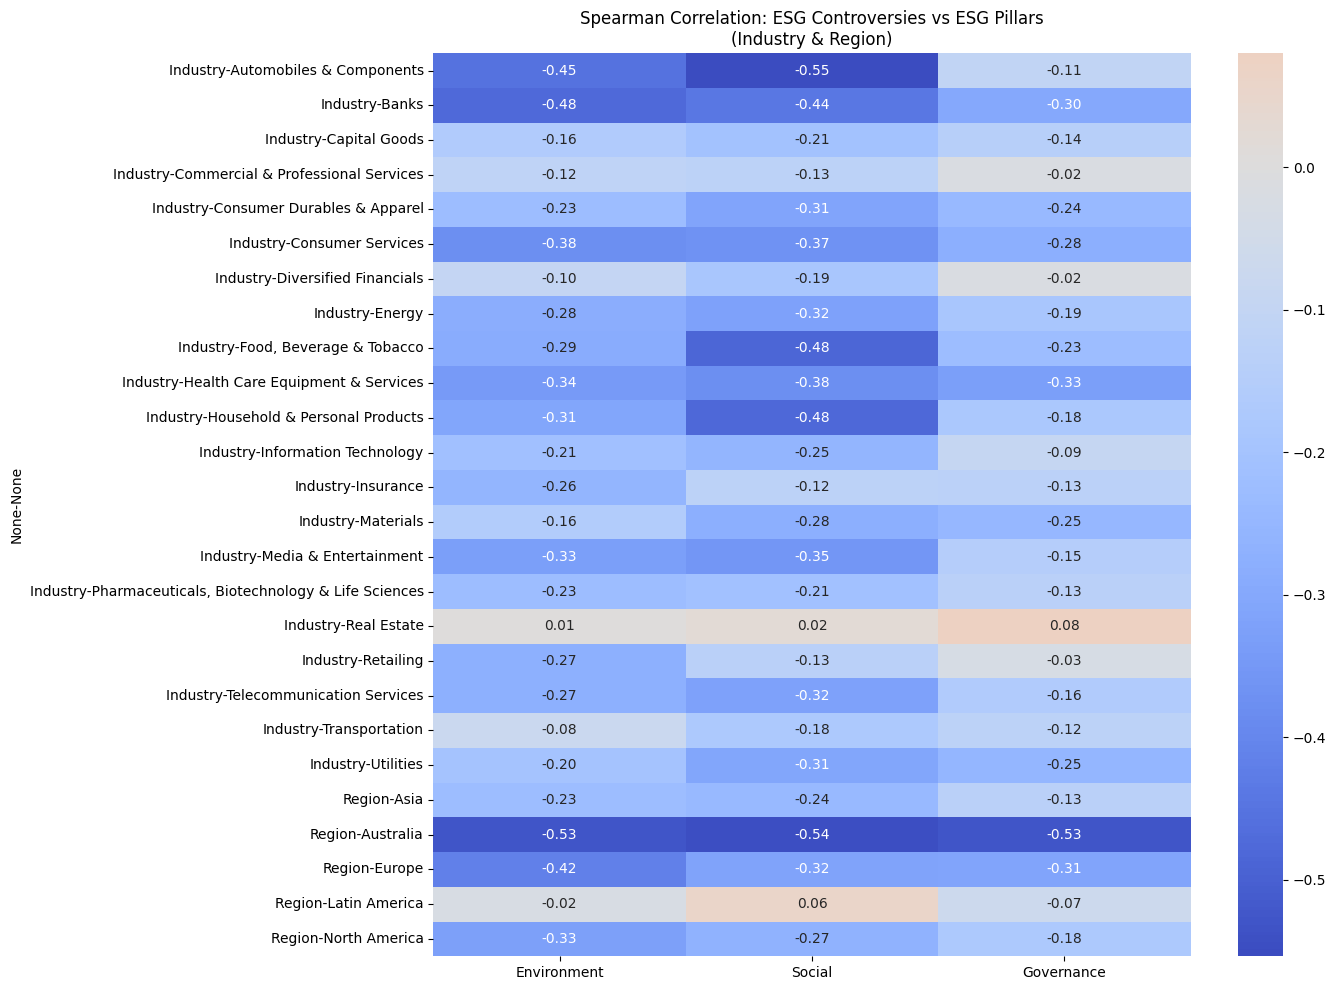

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preparation of Industry Correlations for plotting
industry_all = (
    industry_env_corr[['GICS_Industry_Group', 'Spearman_Environmental']]
    .merge(industry_soc_corr[['GICS_Industry_Group', 'Spearman_Social']], on="GICS_Industry_Group")
    .merge(industry_gov_corr[['GICS_Industry_Group', 'Spearman_Governance']], on="GICS_Industry_Group")
    .set_index('GICS_Industry_Group')
)
industry_all.index.name = "Industry"

# Rename columns
industry_all.rename(columns={
    "Spearman_Environmental": "Environment",
    "Spearman_Social": "Social",
    "Spearman_Governance": "Governance"
}, inplace=True)

# Preparation of Region Correlations for plotting
region_all = (
    region_env_corr[['Region', 'Spearman_Environmental']]
    .merge(region_soc_corr[['Region', 'Spearman_Social']], on="Region")
    .merge(region_gov_corr[['Region', 'Spearman_Governance']], on="Region")
    .set_index('Region')
)
region_all.index.name = "Region"

# Rename columns
region_all.rename(columns={
    "Spearman_Environmental": "Environment",
    "Spearman_Social": "Social",
    "Spearman_Governance": "Governance"
}, inplace=True)

# Combine Industry + Region
combined_corrs = pd.concat({
    "Industry": industry_all,
    "Region": region_all
})

# Plot Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(combined_corrs, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Spearman Correlation: ESG Controversies vs ESG Pillars\n(Industry & Region)")
plt.tight_layout()
plt.show()

# RESEARCH QUESTION 3
*Is there evidence of trade-offs between ESG pillar performances across industries and regions?*

In [ ]:
df_clean = df[['Environmental_Pillar_Score', 'Social_Pillar_Score', 'Governance_Pillar_Score','GICS_Industry_Group', 'Region']].dropna()

# Function to compute inter-pillar Spearman correlations
def compute_interpillar_correlations(data, group_col):
    results = []
    for group, group_df in data.groupby(group_col):
        n = len(group_df)

        # Only compute if group has enough variability
        def safe_corr(x, y):
            if x.nunique() <= 1 or y.nunique() <= 1 or n <= 3:
                return np.nan
            return stats.spearmanr(x, y)[0]

        e_s = safe_corr(group_df['Environmental_Pillar_Score'], group_df['Social_Pillar_Score'])
        e_g = safe_corr(group_df['Environmental_Pillar_Score'], group_df['Governance_Pillar_Score'])
        s_g = safe_corr(group_df['Social_Pillar_Score'], group_df['Governance_Pillar_Score'])

        results.append({
            group_col: group,
            'Spearman_E_vs_S': e_s,
            'Spearman_E_vs_G': e_g,
            'Spearman_S_vs_G': s_g,
            'n': n
        })

    return pd.DataFrame(results)

# Run trade-off detection
industry_tradeoffs = compute_interpillar_correlations(df_clean, 'GICS_Industry_Group')
region_tradeoffs   = compute_interpillar_correlations(df_clean, 'Region')

#  Results
industry_sorted = industry_tradeoffs.sort_values('Spearman_E_vs_S').head(10)
region_sorted   = region_tradeoffs.sort_values('Spearman_E_vs_S')

print("Inter-Pillar Correlations by Industry:")
display(industry_sorted)

print("Inter-Pillar Correlations by Region:")
display(region_sorted)

Inter-Pillar Correlations by Industry:


,GICS_Industry_Group,Spearman_E_vs_S,Spearman_E_vs_G,Spearman_S_vs_G,n
20,Utilities,0.508888,0.357848,0.283932,173
15,"Pharmaceuticals, Biotechnology & Life Sciences",0.517147,0.461340,0.350612,583
14,Media & Entertainment,0.568175,0.401274,0.452258,182
7,Energy,0.610901,0.535600,0.405418,223
6,Diversified Financials,0.611025,0.322909,0.341687,203
5,Consumer Services,0.617321,0.473495,0.394632,158
13,Materials,0.631572,0.389157,0.390107,427
17,Retailing,0.636741,0.266291,0.241708,132
3,Commercial & Professional Services,0.644174,0.438811,0.492203,139
2,Capital Goods,0.677010,0.471460,0.396025,580


Inter-Pillar Correlations by Region:


,Region,Spearman_E_vs_S,Spearman_E_vs_G,Spearman_S_vs_G,n
3,Latin America,0.455602,0.520280,0.337867,118
2,Europe,0.565123,0.484833,0.396027,324
4,North America,0.653432,0.397313,0.374106,2756
0,Asia,0.700149,0.350534,0.362475,1628
1,Australia,0.723408,0.559273,0.236364,10


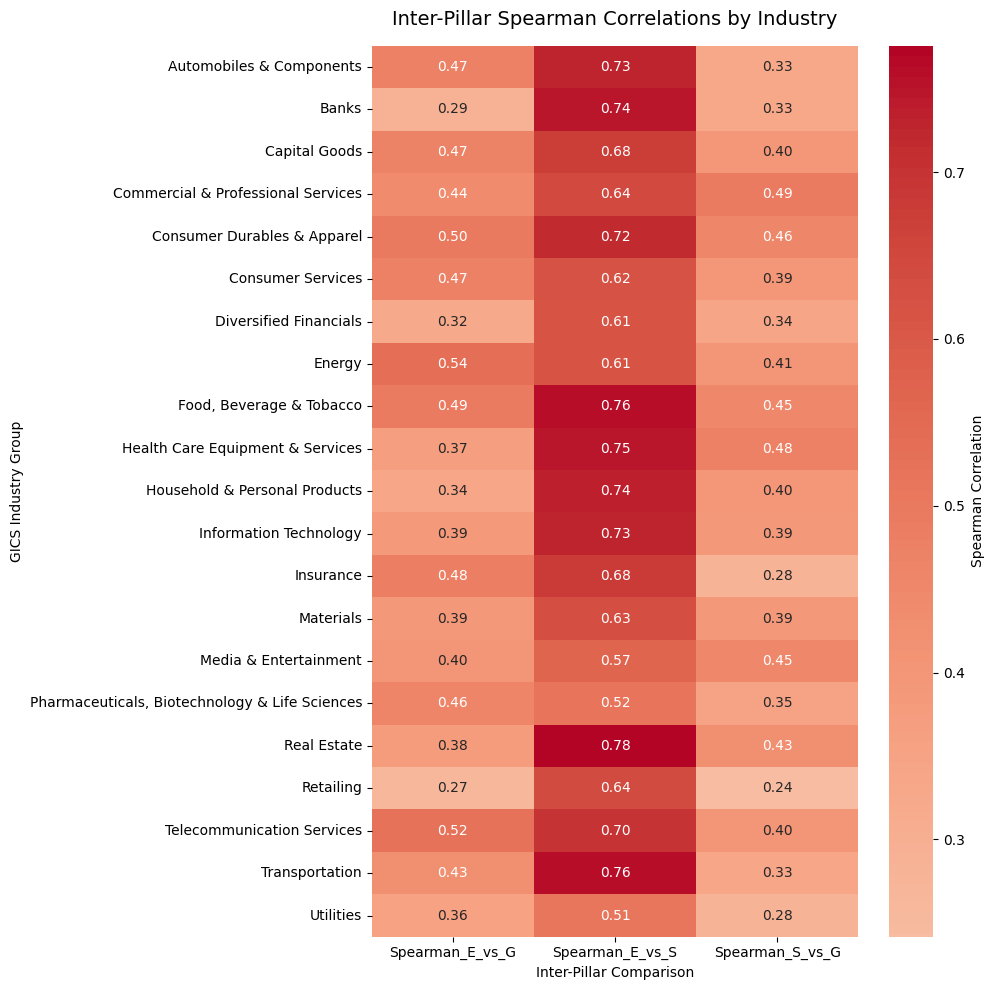

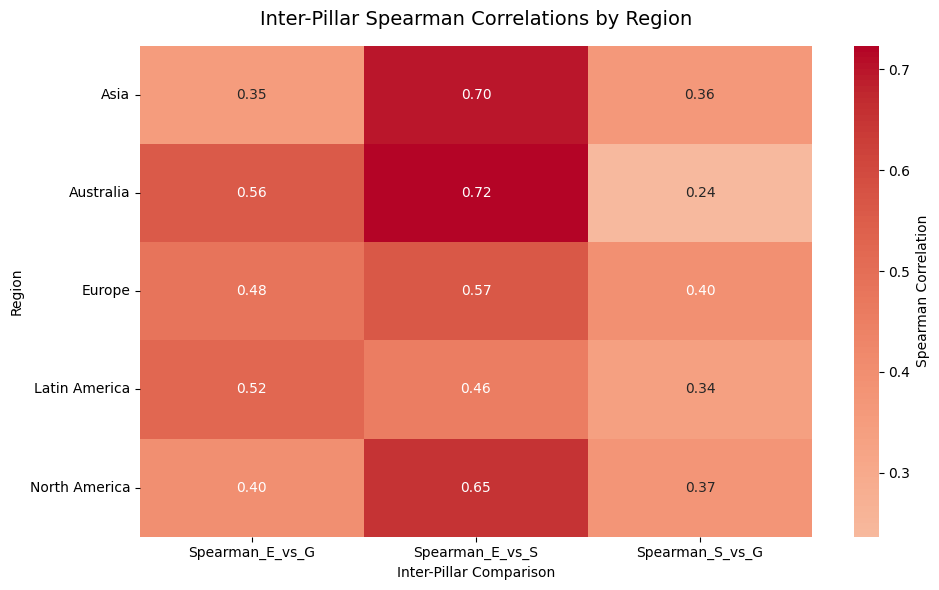

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot results for heatmap plotting
def plot_tradeoff_heatmap(results_df, group_col, title):
    melted = results_df.melt(
        id_vars=[group_col, 'n'],
        value_vars=['Spearman_E_vs_S', 'Spearman_E_vs_G', 'Spearman_S_vs_G'],
        var_name='Comparison',
        value_name='Spearman'
    )

    # Pivot for heatmap
    pivot = melted.pivot(index=group_col, columns='Comparison', values='Spearman')

    # Plot heatmap
    plt.figure(figsize=(10, max(6, len(pivot)//2)))
    sns.heatmap(
        pivot,
        annot=True, fmt=".2f", cmap="coolwarm", center=0,
        cbar_kws={'label': 'Spearman Correlation'}
    )
    plt.title(title, fontsize=14, pad=15)
    plt.xlabel("Inter-Pillar Comparison")
    plt.ylabel(group_col.replace("_", " "))
    plt.tight_layout()
    plt.show()

# Plot heatmaps
plot_tradeoff_heatmap(industry_tradeoffs, 'GICS_Industry_Group',
                      "Inter-Pillar Spearman Correlations by Industry")

plot_tradeoff_heatmap(region_tradeoffs, 'Region',
                      "Inter-Pillar Spearman Correlations by Region")
